**Dataset Selection**

Select a dataset identically to the way you selected for lab one, lab two, or lab three (table data, text data, or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

**Grading Rubric**

**Preparation** (15 points total)

[5 points] (mostly the same as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well should your algorithm perform in order to be useful to third parties. 

[10 points] (mostly the same as from labs one through three) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

**Evaluation** (20 points total)

[10 points] (mostly the same as from lab five) Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] (mostly the same as from lab five) Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

**Modeling** (55 points total)

[35 points] Create a custom ensemble classifier that uses multi-layer perceptron models for the individual classifiers. You can use bagging or boosting to select the training examples for each MLP in the ensemble, whichever you prefer.   

[20 points] Evaluate the performance of the ensemble classifier with your chosen evaluation metric(s). Visualize the results with a confusion matrix, receiver operating characteristic, and area under the curve. Visually compare its performance to the individual classifiers that make up the ensemble.

**Exceptional Work** (10 points total)

You have free reign to provide additional analyses.
One idea: add randomized feature selection to your bagging or boosting models

# Lab 06 - Ensembles

By Erik Gabrielsen, Danh Nguyen, and Conrad Appel

## Business Understanding

In this lab, we are interested in investigating image processing techniques and seeing how well these techniques will work with our custom multilayer perceptron and scikit-learn's. We will be using the CIFAR-10 small images (32x32) dataset, which contains the following labels:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The goal is to have the models predict as well as possible according to the F1 score, since we are interested in seeing how correctly images are classified. The highest score based on accuracy on Kaggle is around .96, but that requires hours and hours of computation time. If we can perform image recognition anywhere near as well with a relatively simple model to implement, then perhaps we have good processing techniques. This project has computer vision applications, and could be applied to robotics and especially people that wants to deploy simple image recognition models without access to large computationally expensive servers. Ideally, we would want our F1 score to be around 90%, so that the majority of images can be accomplished by the computer with some checks by people. 

In [18]:
import os
import sys
import random
import copy
import warnings
from random import randint
import _pickle as cPickle
import pickle
from pathlib import Path
from multiprocessing import Pool, cpu_count
import warnings

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.neural_network import MLPClassifier
from sklearn.utils.validation import check_X_y, check_array
from scipy.misc import imread
from scipy.special import expit
import pywt # conda install -c conda-forge pywavelets
from skimage.filters import roberts
from skimage.feature import daisy
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# a helper plotting function
def plot_gallery(imgs, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(imgs[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [3]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory    
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_color, img_gray, img_labels, img_label_names)

img_color, img_gray, img_labels, img_label_names = get_images()
img_color = None # clear this memory because my computer ugh
img_gray = img_gray
img_labels = img_labels
print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


### Image Preprocessing
For image processing we tried a multitude of different processing techniques. The first was converting the images from To determine the best list of steps for preprocessing our images before training and predicting using our classifier, we started out by trying to get the best score possible using SKLearn's Multi-Layer Perceptron classifier, a model that we can trust to perform reliably well, even at its default settings. According to Kaggle's leaderboards, the absolute highest score for this particular dataset was 95.5% accuracy using a convolutional neural network, which is what we strove for. Under the assumption that we have a classification model that works well, the key to this analysis is the successful preprocessing we do.

The first step along our journey was to try Principal Component Analysis. Theoretically technique would turn our 1024 data points into a much smaller number while at the same time generating a set of components that would hopefully expose the correlations between groups of pixels. Unfortunately, the technique didn't pan out, only giving us about 12% accuracy score, which is just a little better than random guessing. We assume PCA didn't work because it looks at all the pixels on a global scale. Groups of pixels that seem to be correlated in a picture from a class might not be correlated with another picture from the same class, but taken from a different point of view.
The next step was trying an edge-detection algorithm. For this, we used Roberts' algorithm as implemented in Scikit-Image. This algorithm returned a 32px x 32px image (the same size as our input), with only the detected edges showing up in the image. This technique, even though it takes no color or texture information into account, gave us around a 30% accuracy score. On top of the edge detection, we performed a Haar wavelet transform of the images in order to further show us the correlations between local groups of pixels. This transformation helped, but only marginally, giving us about a 32% accuracy.

After being unsatisfied with out results, we turned to academic papers to help us find our solution. According to one such paper, Shouhan Lin, Roland Memisevic, and Kishore Konda experimented with the same CIFAR-10 dataset and achieved a 56.84% accuracy only using a neural network. For preprocessing they used global contrast normalization to create a zero mean, followed by PCA whitening. We implemented these techniques as they described hoping to achieve repeatable results. While the GCN algorithm helped marginally, we could only achieve a \<15% accuracy score with the PCA-based techniques they used. We scrapped the PCA technique-family altogether and moved on.
Next, we simply fed unprocessed, flattened color images into the classifier. To our suprise, this actually gave us a 40% accuracy, which is significantly better than randomly guessing. However, it was still not the best.
Lastly, we thought about the problem some more and affirmed that a transformation that could look at local sections of the image and extract specific features would be necessary to achieve our goals. One such algorithm that fit this category was the DAISY Feature Extraction technique. We put 4 daisies on each image, each with two sets of 8 circles of radius 7, and each circle looking in 5 different directions, for a total of 340 features, which is much less than our original set of 1024 features. This technique finally gave us the key to the classification, giving us around 60% accuracy consistently.

In the end, we stuck with using GCN followed by DAISY feature extraction on grayscale images. In the future, we could further extend this by taking color information into account (many images of the same class will be similarly-colored), or further exploring the ZCA techniques as suggested by the top contenders on Kaggle (perhaps we implemented them incorrectly).

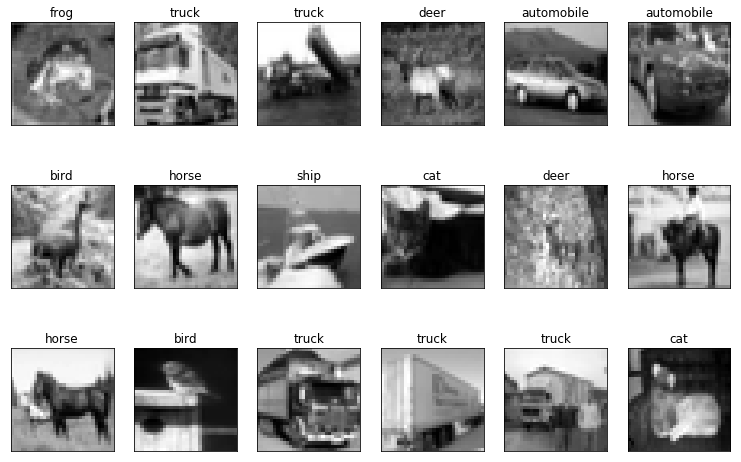

In [4]:
plot_gallery(img_gray, img_label_names, 32, 32) 

/users5/me/danhn/ML/machinelearning/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


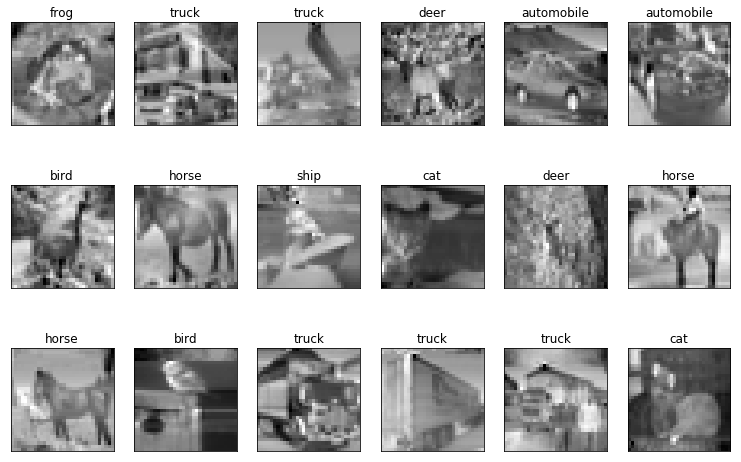

In [5]:
def global_contrast_normalization(x):
    x = x - x.mean(axis=1)[:, np.newaxis]
    normalizers = np.sqrt((x ** 2).sum(axis=1))
    x /= normalizers[:, np.newaxis]
    return x

# contrast normalization
normalized = np.array([np.concatenate(global_contrast_normalization(x.reshape((32, 32)))) for x in img_gray])
plot_gallery(normalized, img_label_names, 32, 32) 

In [8]:
my_file = Path('./imgs/cached_daisies')
if my_file.is_file():
    with open('./imgs/cached_daisies', 'rb') as f:
        daisies = pickle.load(f)
else:
    daisies = np.array([np.concatenate(np.concatenate(daisy(x.reshape((32,32)), step=16, radius=7, rings=2, histograms=8, orientations=5))) for x in img_gray])
    with open('./imgs/cached_daisies', 'wb+') as f:
        pickle.dump(daisies, f)

## Evaluation

### Scoring
We need to choose a method for scoring our classifier, out of accuracy, recall, precision, and F-score. For a start, let's define the four possible cases when classifying an image:

* True Positive: Image is of class X, and we correctly guessed class X.
* True Negative: Image is of class X, and we correctly stated that it wasn't any of the other 9 classes. In our cases, a True Positive also comes with the benefit of having 9 True Negatives.
* False Positive: Image is of class X, and we incorrectly guessed class Y.
* False Negative: Image is of class X, and we didn't guess that it was X. Like the True Negative, if we have a False Positive, we also have a False Negative.

In our case, because the True Positives and True Negatives are all paired up with each other, it would be safe to say that we only need to maximize one of them, as maximizing one intrinsically maximizes the other. As such, we can eliminate accuracy score, because we don't need to account for both. Additionally, because having a False Positive means we have a False Negative paired with it, we can weight each equally. We also want to minimize both False Positives and False Negatives. The only scoring method left that takes all these attributes into account is the F-score. In our case, we use the F1 score, as we want to weigh False Positives and Negatives equally.

### Cross-Validation
We also needed to choose a method for splitting our data set into smaller sets that more closely model a real-life scenario, as we don't get to train over every sample of data that comes in before needing to predict what its outcome will be. We have a couple of tools in our arsenal for cross-validation: simple train-test splits, K-folds, shuffle splits, and stratified K-fold or shuffle splits. Coming into the problem, there are a few properties of our dataset that we can use when making this decision. First off, we know that our set is perfectly balanced - there are exactly 6000 members of each class. Secondly, there is no need for any ordering of our set as it's not a time-series or any other ordered series. Lastly, there shouldn't be any bias in the ordering of members of a class. Because of these three characteristics, we believe that we could reliably pick any of the aforementioned techniques and still get good results. However, some of the techniques are intrinsically better than the others. We do want one of the stratified techniques as there is no reason we should introduce a class imbalance into the mix when there was none before. We also want to actually use a cross-validation technique rather than a simple test-train split, as it helps us to try out every data sample in a training set. This leaves us with either Stratified K-Fold splits or Stratified Shuffle Splits. As randomly selecting X members of each class shouldn't introduce any bias and using a Shuffle Split has the potential to be faster, our final Cross-Validation technique will be the **Stratified Shuffle Split.**

## Modeling

In [83]:
def _get_subset(x, y, replacement=True, samp_percent=.25, return_other=False):
    np.random.seed()
    xy = np.hstack([x, y.reshape((len(y),1))])
    np.random.shuffle(xy)
    size = int(len(y)*samp_percent) if not replacement else len(y)
    indexes = np.random.choice(range(len(y)), size=size, replace=replacement)

    new_x = xy[indexes][:, :-1]
    new_y = xy[indexes][:, -1]

    if not return_other:
        return new_x, new_y
    else:
        inv_indexes = [i for i in range(len(xy)) if i not in indexes]
        alternate_x = xy[inv_indexes][:, :-1]
        alternate_y = xy[inv_indexes][:, -1]
        return new_x, new_y, alternate_x, alternate_y

def do_one_fit(args):
    i = args[0]
    replacement = args[1]
    samp_percent = args[2]
    print_progress = False
    x = args[3]
    y = args[4]
    if print_progress:
        sys.stdout.write('Estimator '+str(i)+' fitting.....')
    new_x, new_y, alt_x, alt_y = _get_subset(x, y, return_other=True, replacement=replacement, samp_percent=samp_percent)
    c = MLPClassifier()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c.fit(new_x, new_y)
    if print_progress:
        sys.stdout.write('testing.....')
    alt_yhat = c.predict(alt_x)
    precision = f1_score(alt_y, alt_yhat, average='weighted')
    if print_progress:
        sys.stdout.write('complete!\n')
    return (c, precision, alt_y, alt_yhat)

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=20, samp_percent=.25, replacement=True, weighted=True, proba_voting=True, n_jobs=-1):
        super().__init__()
        self.n_estimators = n_estimators
        self.samp_percent = samp_percent
        self.replacement = replacement
        self.weighted = weighted
        self.proba_voting = proba_voting   
        self.n_jobs = n_jobs
        
    def fit(self, x, y, print_progress=False):
        x, y = check_X_y(x, y)
        x, y = x.copy(), y.copy()
    
        self.n_features_ = x.shape[1]
        self.n_classes_ = len(np.unique(y))
        self.classes_, y = np.unique(y, return_inverse=True)
        
        pool = Pool(processes=cpu_count() if self.n_jobs <= -1 else n_jobs)
        args = zip(range(self.n_estimators), [self.replacement]*self.n_estimators, [self.samp_percent]*self.n_estimators, [x]*self.n_estimators, [y]*self.n_estimators)
        results = pool.map(do_one_fit, args)
        self.classifiers_ = [q[0] for q in results]
        self.precisions_ = [q[1] for q in results]
        self.sample_ys_ = [q[2] for q in results]
        self.sample_yhats_ = [q[3] for q in results]
        
        return self
    
    def predict(self, x):
        x = check_array(x)
            
        results = np.zeros((x.shape[0], self.n_classes_))
        for classifier, precision in zip(self.classifiers_, self.precisions_):
            if self.proba_voting:
                res = classifier.predict_proba(x)
                results += res * (precision if self.weighted else 1)
            else:
                res = classifier.predict(x).astype(np.int)
                for i in range(len(res)):
                    results[i][res[i]] += precision if self.weighted else 1
        
        # select highest picked class for each row
        res = [np.argmax(x) for x in results]
        res = self.classes_[res]

        return res

In [84]:
p2 = Pipeline([('scaler', StandardScaler()), ('tlp', EnsembleClassifier(n_estimators=50, replacement=True))])
cv = StratifiedShuffleSplit(n_splits=3, test_size=.2)
for train_index, test_index in cv.split(daisies, img_labels):
    p2.fit(daisies[train_index], img_labels[train_index], tlp__print_progress=True)
    yhat = p2.predict(daisies[test_index])
    print('f1 score:', f1_score(img_labels[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

f1 score: 0.667092303697
[1178 1214 1161 1057 1312 1115 1225 1246 1252 1240]
f1 score: 0.662798288905
[1178 1207 1139 1031 1240 1144 1237 1315 1254 1255]
f1 score: 0.654492851429
[1194 1249 1130 1082 1242 1133 1248 1241 1208 1273]


In [80]:
# find best and worst classifiers

to_plot = [np.argmin(p2.named_steps['tlp'].precisions_), np.argmax(p2.named_steps['tlp'].precisions_)]
print(to_plot)

[20, 8]


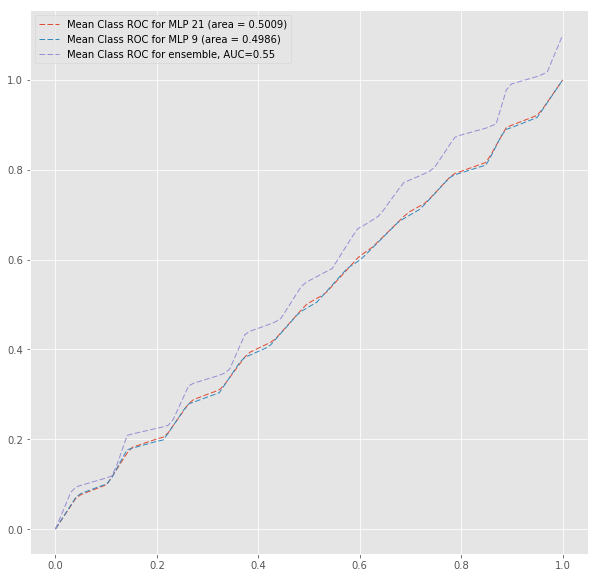

In [81]:
# get fpr and tpr per MLP
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

plt.figure(figsize=(10,10))

for i in to_plot:
    y = p2.named_steps['tlp'].sample_ys_[i]
    y_hat = p2.named_steps['tlp'].sample_yhats_[i]

    roc_auc = 0
    perclass_mean_tpr = 0.0
    classes = np.unique(y)

    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y,
                                         y_hat,
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)

    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC for MLP %d (area = %0.4f)'
                   % (i+1, roc_auc))    

# get fpr and tpr for ensemble
for j in classes:
    fpr, tpr, thresholds = roc_curve(img_labels[test_index],
                                     yhat,
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC for ensemble, AUC=%0.2f'
                 %(roc_auc))
plt.legend(loc='best')

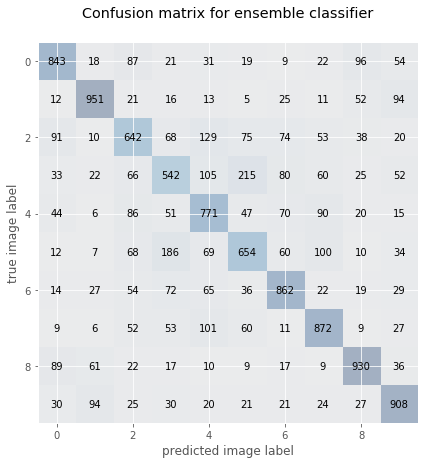

In [82]:
from mlxtend.plotting import plot_confusion_matrix

cf_mat = confusion_matrix(img_labels[test_index], yhat)
fig, ax = plot_confusion_matrix(conf_mat=cf_mat, figsize=(7,7))
plt.title('Confusion matrix for ensemble classifier')
plt.xlabel('predicted image label')
plt.ylabel('true image label')
plt.show()

In [ ]:
# individual class f1 score

for i in range(0, len(conf_mat)):
    f1 = conf_mat[i][i]/np.sum(conf_mat[i])
    print('Class %d F1 score: %0.2f' %(i, ))

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedShuffleSplit(n_splits=1, test_size=.2)
pl = Pipeline([('scaler', StandardScaler()), ('RFC', RandomForestClassifier(n_estimators=100))])
for train_index, test_index in cv.split(x, y):
    %time pl.fit(x[train_index], y[train_index])
    yhat = pl.predict(x[test_index])
    print('f1 score:', f1_score(y[test_index], yhat, average='macro'))
    print(np.bincount(yhat))

## Sources

[1] Zhouhan Lin, Roland Memisevic, Kishore Konda. "How Far can we go without Convolutions: Improving Fully-Connected Networks". <i>Cambridge</i>. 2016. https://arxiv.org/pdf/1511.02580.pdf